In [1]:
import numpy as np
import os
import random
import tensorflow as tf

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from utils import *

2023-07-15 17:46:22.111403: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-15 17:46:28.431739: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
os.environ["PYTHONHASHSEED"] = "0"
random.seed(1234)
np.random.seed(1234)
tf.random.set_seed(1234)

In [3]:
folder_path = './points'

x, y = read_data(folder_path)

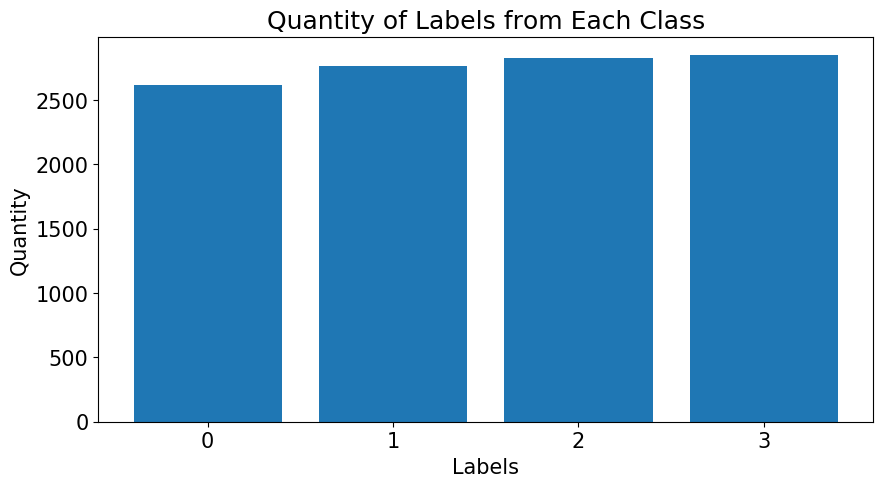

[0 1 2 3]
4


In [4]:
draw_bar_chart(y)

print(np.unique(y))

n_classes = len(np.unique(y))

print(n_classes)

In [5]:
# shuffle
x, y = shuffle(x, y, random_state=0)

# split
x_temp, x_test, y_temp, y_test = train_test_split(x, y, test_size=1/5, random_state=0, stratify=y)

x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=1/4, random_state=0, stratify=y_temp, shuffle=True)

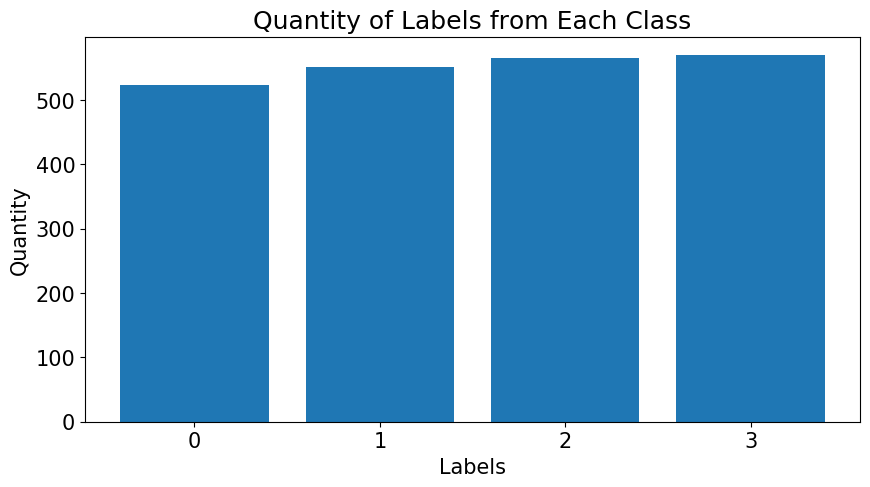

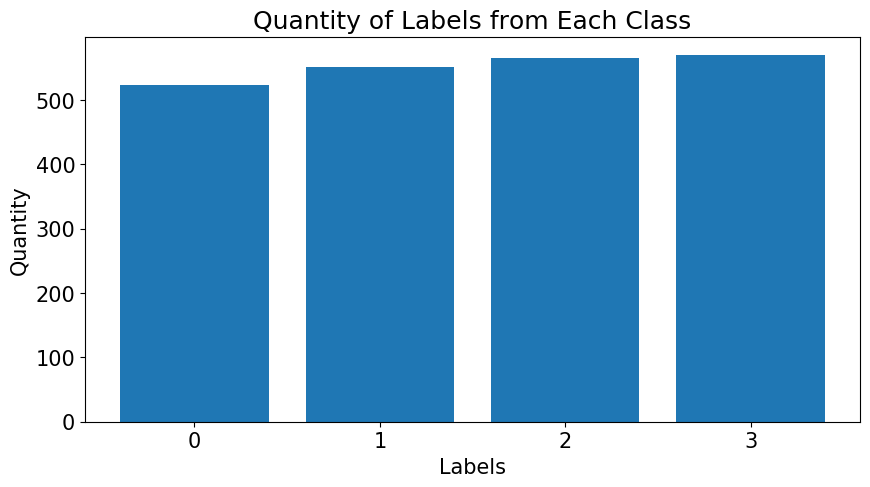

In [6]:
draw_bar_chart(y_val)
draw_bar_chart(y_test)

In [7]:
def create_model(input_shape, dropout=0.5, learning_rate=0.001, kernel_size=3, num_conv_layers=2):
   # Create a `Sequential` model and add a Dense layer as the first layer.
   model = tf.keras.models.Sequential()
   model.add(tf.keras.Input(shape=input_shape))
   for _ in range(num_conv_layers):
      model.add(tf.keras.layers.Conv1D(64, kernel_size, activation='relu'))
   #model.add(tf.keras.layers.MaxPooling1D(2,1))
   model.add(tf.keras.layers.Flatten())
   model.add(tf.keras.layers.Dropout(dropout))
   model.add(tf.keras.layers.Dense(128, activation='relu'))
   model.add(tf.keras.layers.Dropout(dropout))
   model.add(tf.keras.layers.Dense(32, activation='relu'))
   model.add(tf.keras.layers.Dense(n_classes, activation="softmax"))

   model.compile(
      loss="sparse_categorical_crossentropy",
      optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=["sparse_categorical_accuracy"]
   )
   return model

In [8]:
input_shape = x.shape[1:]

model = create_model(input_shape)

model.summary()

callbacks = [keras.callbacks.EarlyStopping(patience=200, restore_best_weights=True)]

results = model.fit(
    x_train,
    y_train,
    validation_data=(x_val,y_val),
    epochs=1,
    batch_size=128,
    callbacks=callbacks,
)

model.evaluate(x_val, y_val, verbose=1)

model.evaluate(x_test, y_test, verbose=1)

2023-07-15 17:46:49.582840: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-15 17:46:49.740769: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-15 17:46:49.741050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 19, 64)            640       
                                                                 
 conv1d_1 (Conv1D)           (None, 17, 64)            12352     
                                                                 
 flatten (Flatten)           (None, 1088)              0         
                                                                 
 dropout (Dropout)           (None, 1088)              0         
                                                                 
 dense (Dense)               (None, 128)               139392    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                4

2023-07-15 17:46:59.710790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8900
2023-07-15 17:47:02.710177: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f812400eed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-15 17:47:02.710226: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 960M, Compute Capability 5.0
2023-07-15 17:47:03.249557: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-15 17:47:05.417274: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 [==============================] - 0s 3ms/step - loss: 1.2728 - sparse_categorical_accuracy: 0.4052


[1.2727713584899902, 0.4052464962005615]

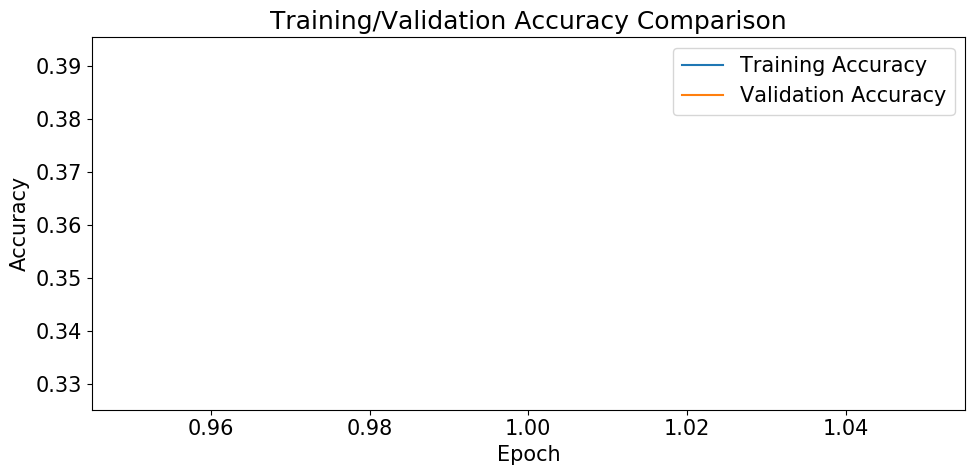

In [9]:
plot_accuracy_comparison([results.history["sparse_categorical_accuracy"], results.history["val_sparse_categorical_accuracy"]],
                        "Training/Validation Accuracy Comparison",
                        ["Training Accuracy", "Validation Accuracy"], save_path="./accuracy_comparison.svg")

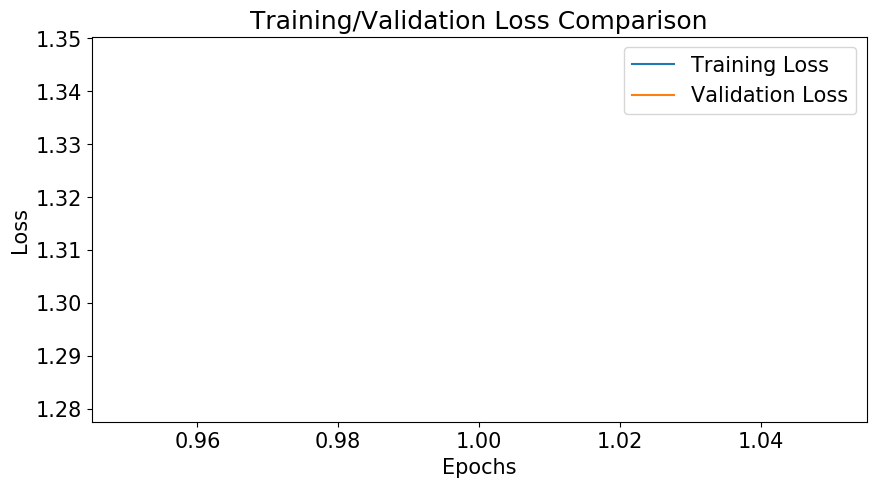

In [10]:
plot_loss_comparison([results.history["loss"], results.history["val_loss"]],
                     "Training/Validation Loss Comparison",
                     ["Training Loss", "Validation Loss"])

70/70 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.60      0.53      0.57       598
           1       0.05      0.35      0.08        75
           2       0.17      0.30      0.22       318
           3       0.80      0.38      0.51      1220

    accuracy                           0.41      2211
   macro avg       0.41      0.39      0.34      2211
weighted avg       0.63      0.41      0.47      2211



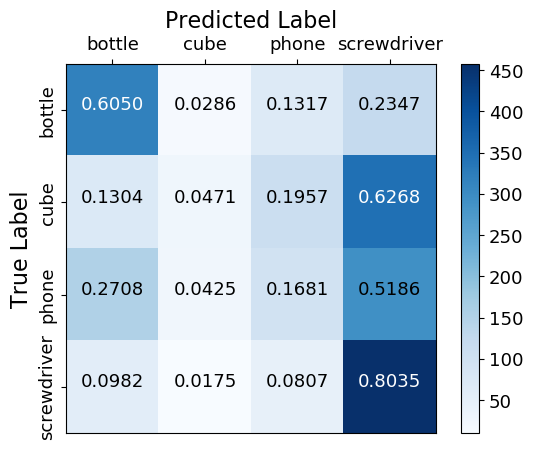

In [11]:
y_pred=np.argmax(model.predict(x_test), axis=-1)
print(classification_report(y_pred,y_test))
plot_confusion_matrix(y_test, y_pred, ["bottle", "cube", "phone", "screwdriver"])

In [12]:
model.save('./models/points_conv_1d.h5')